## NYSE

Original notebook: https://www.kaggle.com/raoulma/ny-stock-price-prediction-rnn-lstm-gru



First, let's download data.

In [0]:
!pip install gdown

In [0]:
!gdown https://drive.google.com/uc?id=1BsBVz1QCN3-KQnrHRx7tFm84yNrZdSdi

Downloading...
From: https://drive.google.com/uc?id=1BsBVz1QCN3-KQnrHRx7tFm84yNrZdSdi
To: /content/nyse.zip
32.1MB [00:01, 19.3MB/s]


We unzip (silently) data and delete zip file afterward.

In [0]:
!unzip -qo 'nyse.zip'
!rm 'nyse.zip'

In [0]:
!ls

fundamentals.csv  prices-split-adjusted.csv  securities.csv
prices.csv	  sample_data


Import, load data and first glance

In [0]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10
test_set_size_percentage = 10

# import all stock prices
df = pd.read_csv("prices-split-adjusted.csv", index_col = 0)
df.info()
df.head()

# number of different stocks
print('\nnumber of different stocks: ', len(list(set(df.symbol))))
print(list(set(df.symbol))[:10])
print('=' * 40)

print(df.describe())
print('=' * 40)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
symbol    851264 non-null object
open      851264 non-null float64
close     851264 non-null float64
low       851264 non-null float64
high      851264 non-null float64
volume    851264 non-null float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB

number of different stocks:  501
['IBM', 'CA', 'RSG', 'PNW', 'CVX', 'PEG', 'JNJ', 'WM', 'CMI', 'AVB']
                open          close            low           high        volume
count  851264.000000  851264.000000  851264.000000  851264.000000  8.512640e+05
mean       64.993618      65.011913      64.336541      65.639748  5.415113e+06
std        75.203893      75.201216      74.459518      75.906861  1.249468e+07
min         1.660000       1.590000       1.500000       1.810000  0.000000e+00
25%        31.270000      31.292776      30.940001      31.620001  1.221500e+06
50%        48.459999      48.480000      47

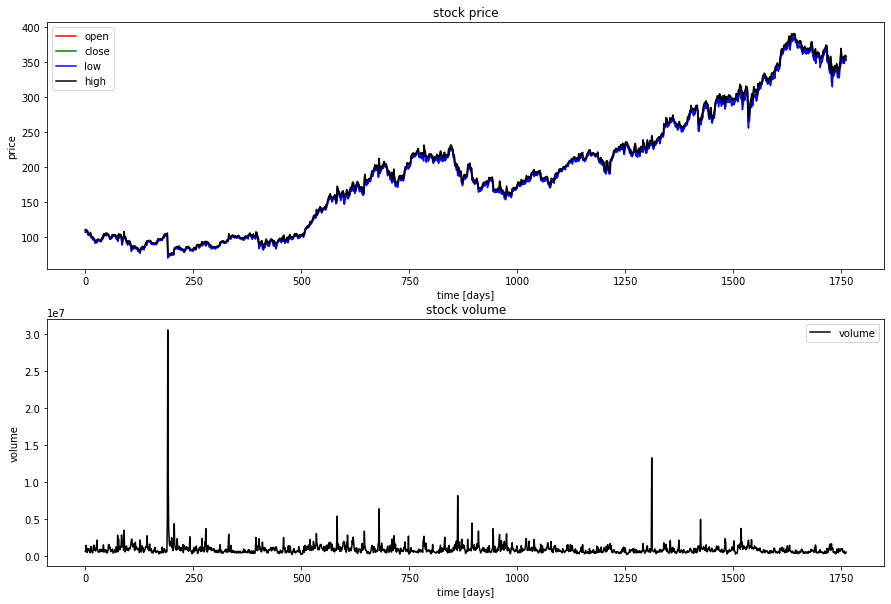

In [0]:
plt.figure(figsize=(15, 10));
plt.subplot(2, 1, 1)
plt.plot(df[df.symbol == 'EQIX'].open.values, color='red', label='open')
plt.plot(df[df.symbol == 'EQIX'].close.values, color='green', label='close')
plt.plot(df[df.symbol == 'EQIX'].low.values, color='blue', label='low')
plt.plot(df[df.symbol == 'EQIX'].high.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')

plt.subplot(2, 1, 2);
plt.plot(df[df.symbol == 'EQIX'].volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best')
plt.show()

In [0]:
# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))  # ? row, 1 column
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    if 'volume' in df:
      df['volume'] = min_max_scaler.fit_transform(df['volume'].values.reshape(-1,1))
    return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.values  # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]



# choose one stock
df_stock = df[df.symbol == 'EQIX'].copy()
df_stock.drop(['symbol'],1,inplace=True)
# Comment next line to use volume
df_stock.drop(['volume'],1,inplace=True)

cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols)



# # Modify
# data_raw = df_stock_norm.values
# valid_set_size = int(np.round(valid_set_size_percentage/100*nbs))
# test_set_size = int(np.round(test_set_size_percentage/100*nbs))
# train_set_size = nbs - (valid_set_size + test_set_size)

# data_raw=stock.values
# x_train=data_raw[:train_set_size]
# x_valid=data_raw[train_set_size:train_set_size+valid_set_size]
# x_test=data_raw[train_set_size+valid_set_size:]

# min_max_scaler=sklearn.preprocessing.MinMaxScaler()
# for can in range(x_train.shape[1]):
#   min_max_scaler.fit(x_train[:,0])
#   x_train[:,can:can+1]=min_max_scaler.transform(x_train[:,can:can+1])
#   x_valid[:,can:can+1]=min_max_scaler.transform(x_valid[:,can:can+1])
#   x_test[:,can:can+1]=min_max_scaler.transform(x_test[:,can:can+1])

# seq_len=20

# data=[]
# for index in range(x_train.shape[0]-seq_len):
#   data.append(x_train[index:index+seq_len])
# x_train=np.array(data)

# data=[]
# for index in range(x_valid.shape[0]-seq_len):
#   data.append(x_valid[index:index+seq_len])
# x_train=np.array(data)

# data=[]
# for index in range(x_test.shape[0]-seq_len):
#   data.append(x_test[index:index+seq_len])
# x_train=np.array(data)

# #7,20,4
# y_train=x_train[:,-1,:]
# y_valid=x_valid[:,-1,:]
# y_test=x_test[:,-1,:]

# x_train=x_train[:,:-1,:]
# x_valid=x_valid[:,:-1,:]
# x_test=x_test[:,:-1,:]

# # Modified




# normalize stock
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

df_stock.columns.values =  ['open', 'close', 'low', 'high']
x_train.shape =  (1394, 19, 4)
y_train.shape =  (1394, 4)
x_valid.shape =  (174, 19, 4)
y_valid.shape =  (174, 4)
x_test.shape =  (174, 19, 4)
y_test.shape =  (174, 4)


In [0]:
# 19:window  4:'open', 'close', 'low', 'high'  1394,174:time

<Figure size 1080x360 with 0 Axes>

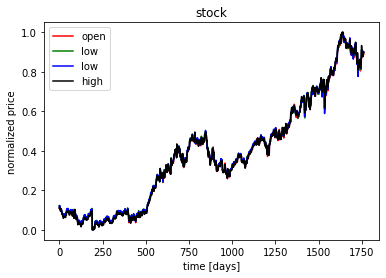

<Figure size 1080x360 with 0 Axes>

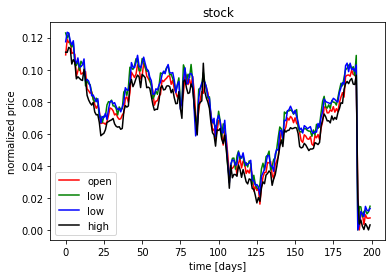

In [0]:
plt.figure(figsize=(15, 5))
fig, ax1 = plt.subplots()
ax1.plot(df_stock_norm.open.values, color='red', label='open')
ax1.plot(df_stock_norm.close.values, color='green', label='low')
ax1.plot(df_stock_norm.low.values, color='blue', label='low')
ax1.plot(df_stock_norm.high.values, color='black', label='high')
ax1.set_ylabel('normalized price')
if 'volume' in df_stock_norm:
  ax2 = ax1.twinx()
  ax2.plot(df_stock_norm.volume.values, color='gray', label='volume')
  ax2.set_ylabel('normalized volume')
plt.title('stock')
plt.xlabel('time [days]')
plt.legend(loc='best')
plt.show()

st_zoom, si_zoom = 0, 200
zoom = np.arange(st_zoom, st_zoom + si_zoom).astype(np.int)
plt.figure(figsize=(15, 5))
fig, ax1 = plt.subplots()
ax1.plot(df_stock_norm.open.values[zoom], color='red', label='open')
ax1.plot(df_stock_norm.close.values[zoom], color='green', label='low')
ax1.plot(df_stock_norm.low.values[zoom], color='blue', label='low')
ax1.plot(df_stock_norm.high.values[zoom], color='black', label='high')
ax1.set_ylabel('normalized price')
if 'volume' in df_stock_norm:
  ax2 = ax1.twinx()
  ax2.plot(df_stock_norm.volume.values[zoom], color='gray', label='volume')
  ax2.set_ylabel('normalized volume')
plt.title('stock')
plt.xlabel('time [days]')
plt.legend(loc='best')
plt.show()

In [0]:
# parameters
n_steps = seq_len-1  # 20-1=19
n_inputs = 4 if 'volume' not in df_stock_norm else 5  # open, close, low. high=4,  with volume=5
n_neurons = 200 
n_outputs = 4 if 'volume' not in df_stock_norm else 5
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100

In [0]:
## Basic Cell RNN in tensorflow

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs]) # 3d tensor
y = tf.placeholder(tf.float32, [None, n_outputs])

# use Basic RNN Cell
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]

# use Basic LSTM Cell 
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# use GRU cell
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for upd

Let's do the same network using Keras

In [0]:
# ==== Do some magic here ====
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, LSTM, Dropout, Input

model = Sequential()

model.add(Input(shape=(n_steps,n_inputs)))

for _ in range(n_layers):
  model.add(LSTM(units=n_neurons,return_sequences=True,activation='relu'))

model.add(Flatten())
model.add(Dense(units=n_outputs,activation='linear'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),loss=tf.keras.losses.MSE)

model.fit(x_train,y_train,validation_data=(x_valid,y_valid),epochs=n_epochs,batch_size=batch_size)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1394 samples, validate on 174 samples
Epoch 1/100
1394/1394 [==============================] - 3s 2ms/sample - loss: 0.0195 - val_loss: 0.0040
Epoch 2/100
1394/1394 [==============================] - 2s 1ms/sample - loss: 7.3121e-04 - val_loss: 0.0014
Epoch 3/100
1394/1394 [==============================] - 2s 1ms/sample - loss: 6.0192e-04 - val_loss: 0.0014
Epoch 4/100
1394/1394 [==============================] - 2s 1ms/sample - loss: 5.7277e-04 - val_loss: 0.0014
Epoch 5/100
1394/1394 [==============================] - 2s 1ms/sample - loss: 5.7415e-04 - val_loss: 0.0014
Epoch 6/100
1394/1394 [==============================] - 2s 1ms/sample - loss: 5.2467e-04 - val_loss: 0.0014
Epoch 7/100
1394/1394 [==============================] - 2s 1ms/sample - loss: 5.1656e-04 - val_loss: 0.0016
Epoch 8/100
1394/13

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 19, 200)           164000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 19, 200)           320800    
_________________________________________________________________
flatten (Flatten)            (None, 3800)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 15204     
Total params: 500,004
Trainable params: 500,004
Non-trainable params: 0
_________________________________________________________________


In [0]:
  y_train_pred = model.predict(x_train)
  y_valid_pred = model.predict(x_valid)
  y_test_pred = model.predict(x_test)

In [0]:
y_train.shape

(1394, 4)

correct sign prediction for close - open price for train/valid/test: 0.75/0.64/0.61


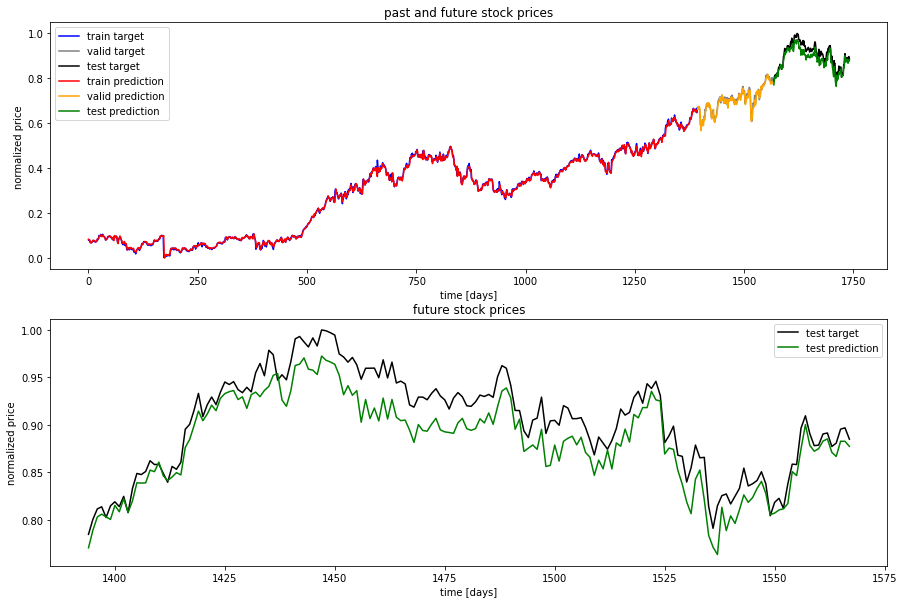

In [0]:
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest

## show predictions
plt.figure(figsize=(15, 10));
plt.subplot(2, 1, 1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('past and future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.subplot(2, 1, 2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))